In [1]:
import jax.numpy as np
from jax import jit
from discopy import Tensor
Tensor.np = np

import discopy

## Corpus Generation

In [2]:
from discopy import Diagram, Id, Cup, Ty, Word
from sklearn.model_selection import train_test_split

# Define our variables via discopy
s, n = Ty('s'), Ty('n') # Grammer types
Alice, Bob, Eve = Word('Alice', n), Word('Bob', n), Word('Eve', n)
loves, hates, kills =  Word('loves', n.r @ s @ n.l),  Word('hates', n.r @ s @ n.l) , Word('kills', n.r @ s @ n.l)

# Establish our grammar
grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)

# Generate our dataset
sentences=[]
parsing = {"{} {} {}".format(subj, verb, obj): subj @ verb @ obj >> grammar
            for subj in [Alice, Bob, Eve] for verb in [loves, hates, kills] for obj in [Alice, Bob, Eve]}

for phrase in parsing:
    sentences.append(phrase)
    
# Let's split our data into training, dev, and test set
train_sentences, test_sentences = train_test_split(sentences, test_size=0.5, random_state=42)
test_sentences, dev_sentences= train_test_split(test_sentences, test_size=0.5, random_state=42)

# Print our datasets 
print("Training set:\n{}\n".format('\n'.join(train_sentences)))
print("Testing set:\n{}\n".format('\n'.join(map(str, test_sentences))))
print("Dev set:\n{}".format('\n'.join(map(str, dev_sentences))))

Training set:
Bob kills Alice
Eve hates Bob
Alice hates Alice
Eve kills Bob
Eve hates Eve
Eve loves Alice
Eve kills Eve
Eve loves Eve
Alice kills Bob
Bob loves Bob
Bob hates Eve
Eve loves Bob
Alice kills Alice

Testing set:
Bob hates Bob
Alice loves Eve
Alice loves Alice
Bob kills Eve
Alice loves Bob
Eve hates Alice
Bob kills Bob

Dev set:
Eve kills Alice
Alice hates Bob
Alice kills Eve
Alice hates Eve
Bob loves Eve
Bob hates Alice
Bob loves Alice


In [3]:
# Assignate true(1) and false(0) labels to our data (random)
train_labels = [1, 1, 1, 1, 1, 1,0,0,0,0,0,0,0]
dev_labels = [1,1,1,0,0,0,0]
test_labels = [0,0,0,1,1,1,1]

train_labels = np.array(train_labels)
dev_labels = np.array(dev_labels)
test_labels = np.array(test_labels)

# Sentences into diagrams

In [4]:
#******************************************
# Generate your diagrams
#******************************************
# TODO generate the DisCoCat diagrams for your corpus. There are 2 options:
# 1. Follow a few fixed templates (N V N, N V Adj N, ...)
# 2. Use the online tool to generate diagrams. 
# If you are using the online tool, consider writing a script.

# Suggestion: print out some of your DisCoCat diagrams using
# `grammar.draw` to check that they make sense.

# TODO implement sentence2diagram
tv = n.r @ s @ n.l

def sentence2diagram(s):
    for subj, verb, obj in [s.split(' ')]:
        diagram = Word(subj, n) @ Word(verb, tv) @ Word(obj, n) >> grammar
    return diagram

train_diagrams = [sentence2diagram(s) for s in train_sentences]
dev_diagrams = [sentence2diagram(s) for s in dev_sentences]
test_diagrams = [sentence2diagram(s) for s in test_sentences]


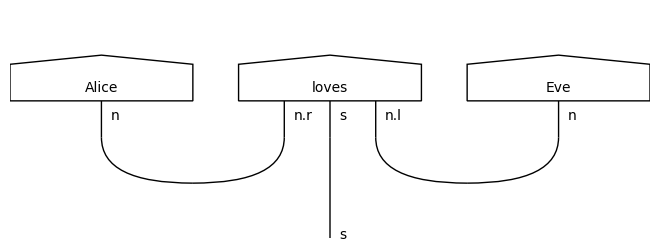

In [5]:
#from sympy.abc import phi
from discopy.grammar import draw
draw(test_diagrams[1], draw_type_labels=True)

# Diagrams into circuits

In [6]:
from discopy.quantum import Ket, H, Rx, CX, sqrt

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

print(verb_ansatz(0).eval())


Tensor(dom=Dim(1), cod=Dim(2, 2), array=[0.99999994+0.j, 0.    +0.j, 0.    +0.j, 0.99999994+0.j])


Circuit for 'train_sentences[0]': Bob kills Alice


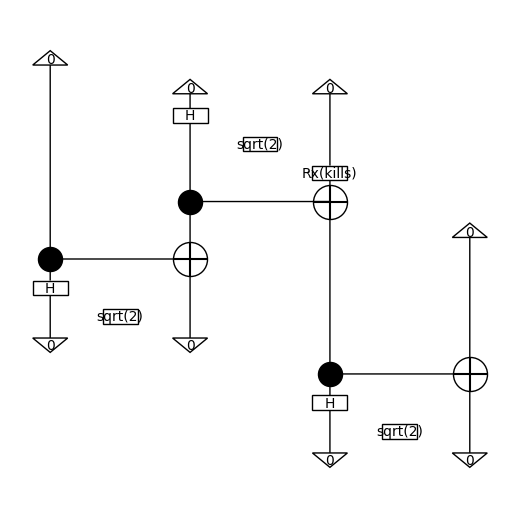

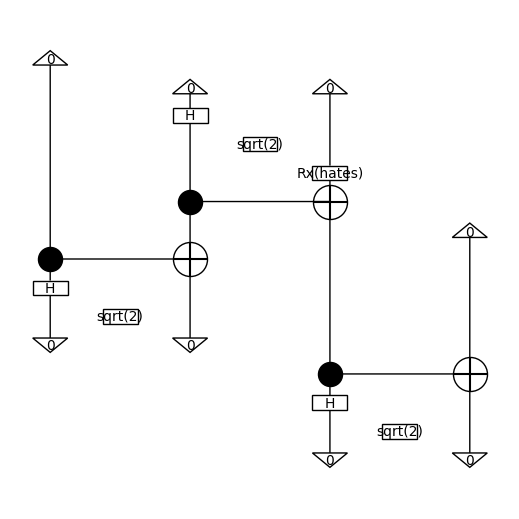

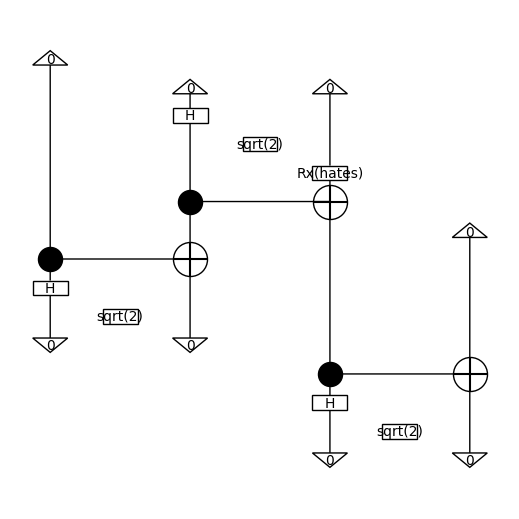

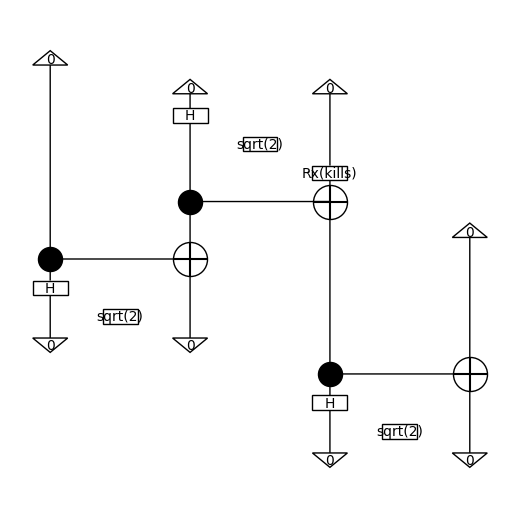

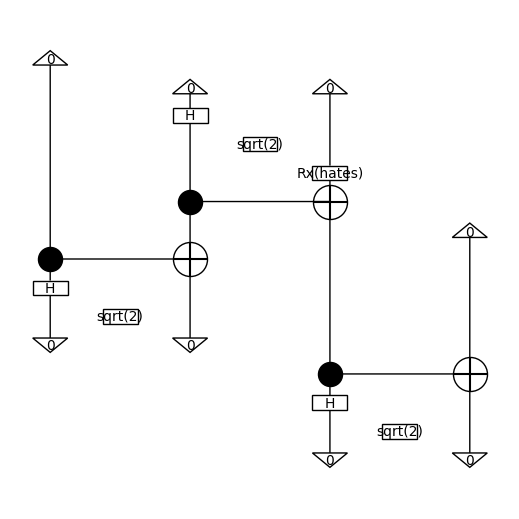

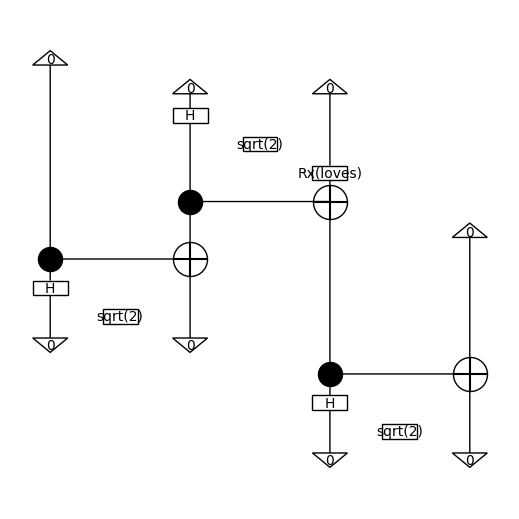

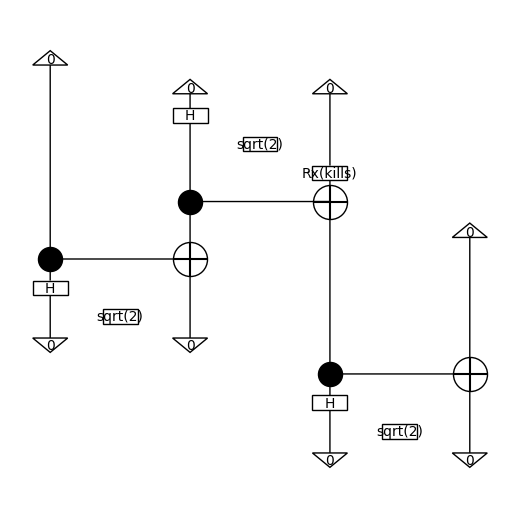

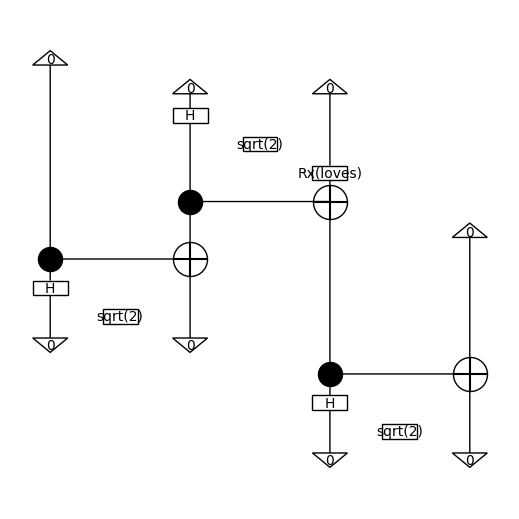

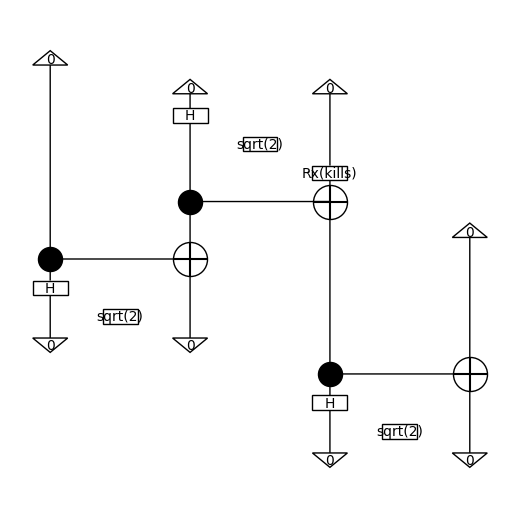

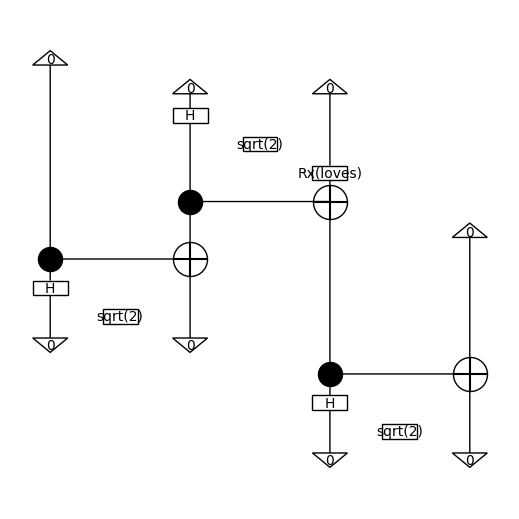

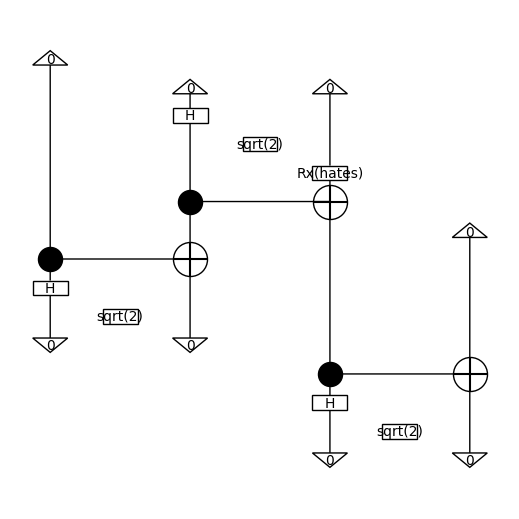

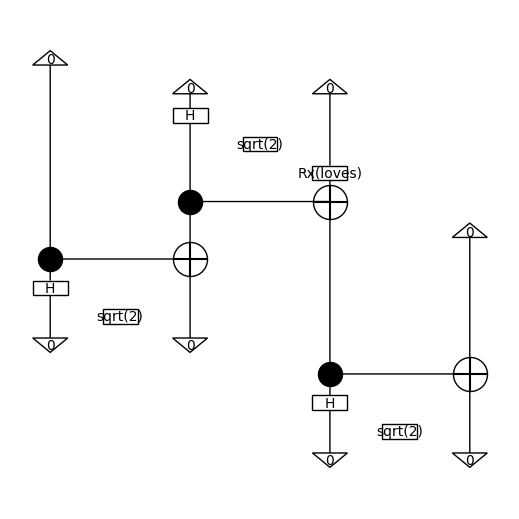

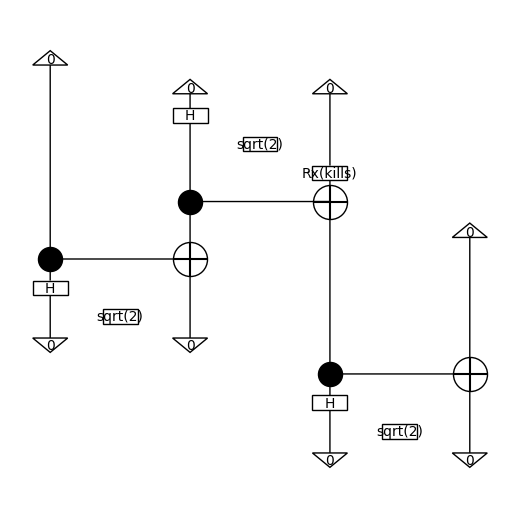

In [39]:
from discopy import CircuitFunctor, qubit
from discopy import drawing
from discopy.quantum import Id, Rz, CX, CRz
from sympy.abc import symbols, phi


ob = {s: Ty(), n: qubit}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(0), Eve: Ket(0),
    kills: verb_ansatz(symbols("kills")),
    loves: verb_ansatz(symbols("loves")),
    hates: verb_ansatz(symbols("hates"))}

F = lambda params: CircuitFunctor(ob, ar(params))
params = symbols("kills loves hates")

print("Circuit for 'train_sentences[0]':", train_sentences[0])

for i in train_sentences:
    F(params)(parsing[i]).draw(
        aspect='auto', draw_type_labels=False, figsize=(5, 5))

In [40]:
def diagram2circuit(d):
    # d: sentence
    quantum_circuit = F(params)(parsing[d])
    return quantum_circuit

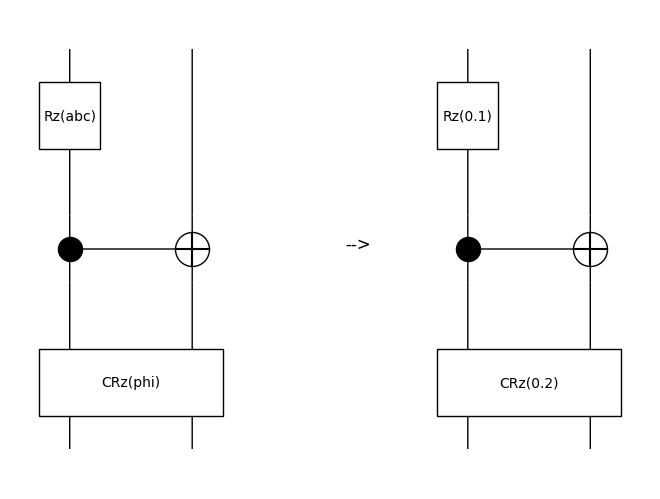

In [41]:
#******************************************
# Generate your circuits
#******************************************
# TODO: Implement your own functorial ansatz conversion!
# The `qnlp-tutorial` has some code on this.
# https://discopy.readthedocs.io/en/main/notebooks/qnlp-tutorial.html
# You may also find discopy's `IQPansatz` function useful.

# Suggestion: Draw some DisCoCat diagrams alongside their circuit diagrams
# and compare them

# TODO implement diagram2circuit
#diagram2circuit = None

train_circuits = [diagram2circuit(d) for d in train_sentences]
dev_circuits = [diagram2circuit(d) for d in dev_sentences]
test_circuits = [diagram2circuit(d) for d in test_sentences]

# You can define parameterised circuits in DisCoPy
# using sympy variables, then substituting them using `lambdify`
from discopy import drawing
from discopy.quantum import Id, Rz, CX, CRz
from sympy.abc import symbols, phi


sym = symbols("abc")
circ = Rz(sym) @ Id(1) >> CX >> CRz(phi)
drawing.equation(circ, circ.lambdify(sym, phi)(0.1, 0.2), symbol='-->')

In [42]:
from sympy import default_sort_key
circuits = train_circuits + dev_circuits + test_circuits

# Make sure you sort your symbols as they are returned as a set.
parameters = sorted({
    s for circ in circuits for s in circ.free_symbols
}, key=default_sort_key)

In [43]:
parameters

[hates, kills, loves]

In [44]:
def normalise(predicts):
    # apply smoothing to predicts
    predicts = np.abs(predicts - 1e-9)
    predicts = predicts / predicts.sum()
    return predicts

def BCE_loss(predicts, labels):
    cross_entropies = np.sum(labels * np.log2(predicts))
    cost = -1/len(labels) * np.sum(cross_entropies)

    return cost

In [45]:
def make_pred_fn(circuits):
    def pred_fn(params):
        predictions = np.array([
            normalise(np.abs(c.lambdify(*parameters)(*params).eval().array))
            for c in circuits
        ])
        return predictions

    return pred_fn

In [46]:
train_pred_fn = jit(make_pred_fn(train_circuits))
dev_pred_fn = jit(make_pred_fn(dev_circuits))
test_pred_fn = jit(make_pred_fn(test_circuits))

import numpy as onp
onp.random.seed(0)

x0 = np.array(onp.random.random(len(parameters)))
print("Performing Just-In-Time compilation, this may take a while...")
train_pred_fn(x0)

Performing Just-In-Time compilation, this may take a while...


DeviceArray([[1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [47]:
dev_pred_fn(x0)

DeviceArray([[1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.],
             [1.]], dtype=float32)

In [48]:
def make_cost_fn(pred_fn, labels):
    costs = []
    accs = []
    params_list = []
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = BCE_loss(predictions, labels)
        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2
        costs.append(cost)
        accs.append(acc)
        params_list.append(params)

        return cost

    return cost_fn, costs, accs, params_list

In [49]:
# Rerun this cell onwards, so you can reuse the JITed prediction functions

train_cost_fn, train_costs, train_accs, spsa_params = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs, callback_params = make_cost_fn(dev_pred_fn, dev_labels)
test_cost_fn, test_costs, test_accs, _ = make_cost_fn(test_pred_fn, test_labels)

In [50]:
from noisyopt import minimizeSPSA
minimizeSPSA(train_cost_fn, x0=x0, a=0.13, c=0.1, niter=2000, callback=dev_cost_fn)

     fun: DeviceArray(-0., dtype=float32)
 message: 'terminated after reaching max number of iterations'
    nfev: 4000
     nit: 2000
 success: True
       x: DeviceArray([0.5488135 , 0.71518934, 0.60276335], dtype=float32)

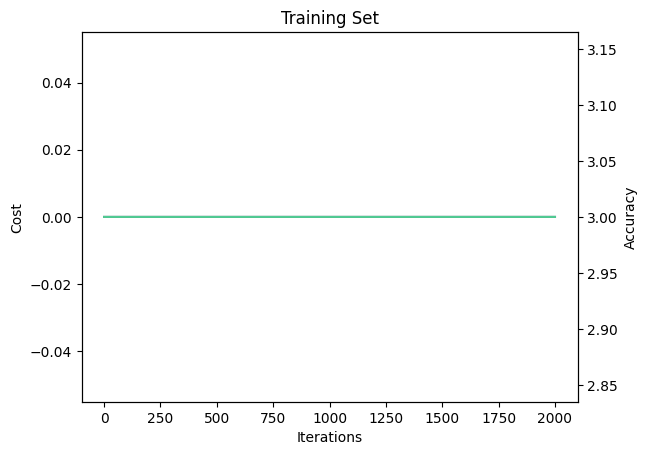

In [51]:
import matplotlib.pylab as plt
fig, ax1 = plt.subplots()
ax1.plot(train_costs[::2], color='#54436B')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Training Set')

ax2 = ax1.twinx()
ax2.plot(train_accs[::2], color='#50CB93')
ax2.set_ylabel('Accuracy')
plt.show()

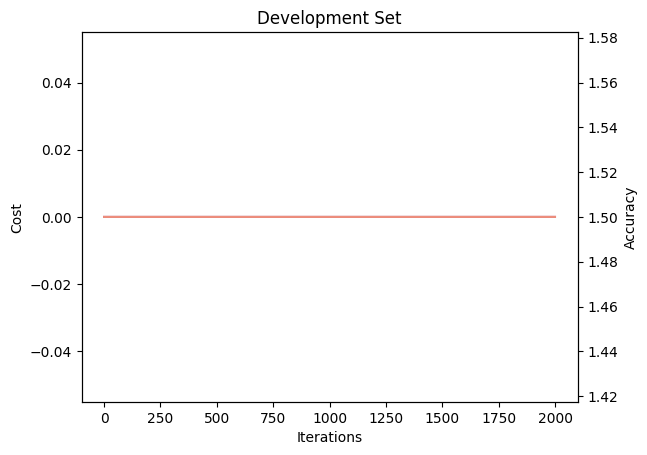

In [21]:
fig, ax1 = plt.subplots()
ax1.plot(dev_costs, color='#A03C78')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Development Set')

ax2 = ax1.twinx()
ax2.plot(dev_accs, color='#ED8E7C')
ax2.set_ylabel('Accuracy')
plt.show()

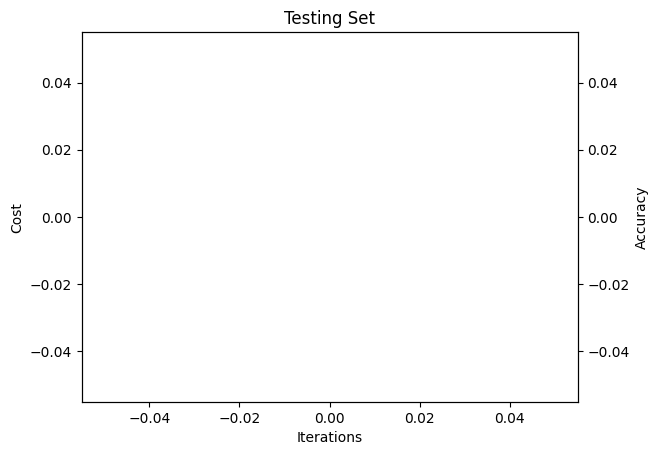

In [22]:
fig, ax1 = plt.subplots()
ax1.plot(test_costs, color='#7C83FD')
ax1.set_ylabel('Cost')
ax1.set_xlabel('Iterations')
ax1.set_title('Testing Set')

ax2 = ax1.twinx()
ax2.plot(test_accs, color='#96BAFF')
ax2.set_ylabel('Accuracy')
plt.show()